## Imports and preparations

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from model_estimation import estimate_model_performance
from preprocessing_utils import EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder, standardize_data
from sklearn.model_selection import train_test_split
import seaborn as sns
from data_completeness import fill_missing_data
from remove_outliers import impute_zscore_test
from dimension_reduction import compare_pca_and_forward_selection
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from predictions_pipeline import PredictionsPipeline
import warnings

warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
test_data = pd.read_csv("test.csv")

## Data Exploration

### We will start with a glimpse of data and its features:

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
print(f"Data description:")
train_data.describe()

Data description:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
count,10479.00000,9874.000000,10066.000000,9792.000000,10076.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10156.000000,10460.000000,10456.000000,105.000000,10479.000000
mean,5239.00000,2.321957,80.462468,0.502655,31.870187,1302.457216,0.021854,0.042859,5.900387,0.061985,2.122981,3.155641,99.769628,4.060440,0.154690
std,3025.17107,3.335331,179.217548,1.265812,44.816259,2039.312905,0.048100,0.048297,18.727496,0.199429,0.906859,2.404672,10.050268,2.189818,0.361626
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,60.733919,-1.235571,0.000000
25%,2619.50000,0.000000,0.000000,0.000000,7.000000,221.000000,0.000000,0.014283,0.000000,0.000000,2.000000,1.000000,93.030568,3.141657,0.000000
50%,5239.00000,1.000000,8.000000,0.000000,18.000000,677.851191,0.002968,0.025161,0.000000,0.000000,2.000000,3.000000,99.787249,4.432221,0.000000
75%,7858.50000,4.000000,93.000000,0.000000,38.000000,1605.733333,0.016667,0.050000,0.000000,0.000000,3.000000,4.000000,106.506626,5.531061,0.000000
max,10478.00000,27.000000,3398.750000,24.000000,705.000000,47850.920680,0.200000,0.200000,361.763742,1.000000,8.000000,9.000000,141.735142,7.618254,1.000000


In [6]:
print(f"Data glimpse:")
train_data.head()

Data glimpse:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.0,0.0,Feb,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,0.0,0.0,Feb,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,0.0,0.0,Feb,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,0.0,0.0,Feb,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.0,0.4,Feb,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


In [7]:
print(f"Number of rows: {train_data.shape[0]}")
print(f"Number of features: {train_data.shape[1]-1}")

Number of rows: 10479
Number of features: 22


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10479 entries, 0 to 10478
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10479 non-null  int64  
 1   num_of_admin_pages     9874 non-null   float64
 2   admin_page_duration    10066 non-null  float64
 3   num_of_info_pages      9792 non-null   float64
 4   info_page_duration     10162 non-null  object 
 5   num_of_product_pages   10076 non-null  float64
 6   product_page_duration  9858 non-null   object 
 7   total_duration         5726 non-null   float64
 8   BounceRates            10457 non-null  float64
 9   ExitRates              10453 non-null  float64
 10  PageValues             10452 non-null  float64
 11  closeness_to_holiday   9983 non-null   float64
 12  Month                  10454 non-null  object 
 13  device                 10156 non-null  float64
 14  internet_browser       9916 non-null   object 
 15  Re

At first, we tried to look at the data and get familiar with it how it looks, and which data types are used for each column.
We used df.describe, df. head and df.info to just have a glimpse at the data and "feel" how it behaves.
It will later help us to understand how we would like to manipulate it in our favor. <br>
We already noticed some interesting things:
1. We have some columns of type "object". Leaving them like that will prevent us from use it in some of our model predictions. We will prefer to use them as dummy variables instead. <br>
2. Some of the columns are a mix of numbers and strings, we will have to normalize them in order to use them properly.<br>
3. We saw that our columns contain NaN values, we will have to fill-in these NaNs in actual values. We will try to predict the values later on.<br>

### Let's try to see how that data distributes:

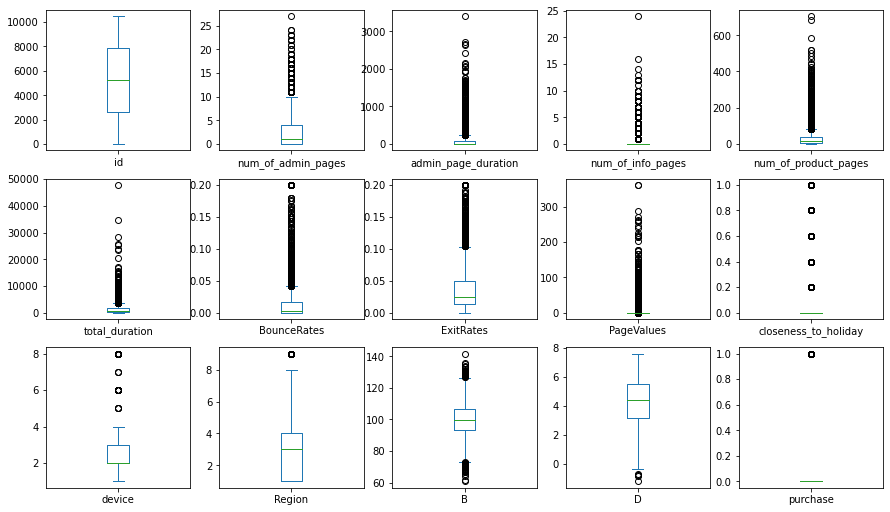

In [9]:
train_data.plot(kind="box", subplots=True,layout = (5,5), figsize=(15,15));

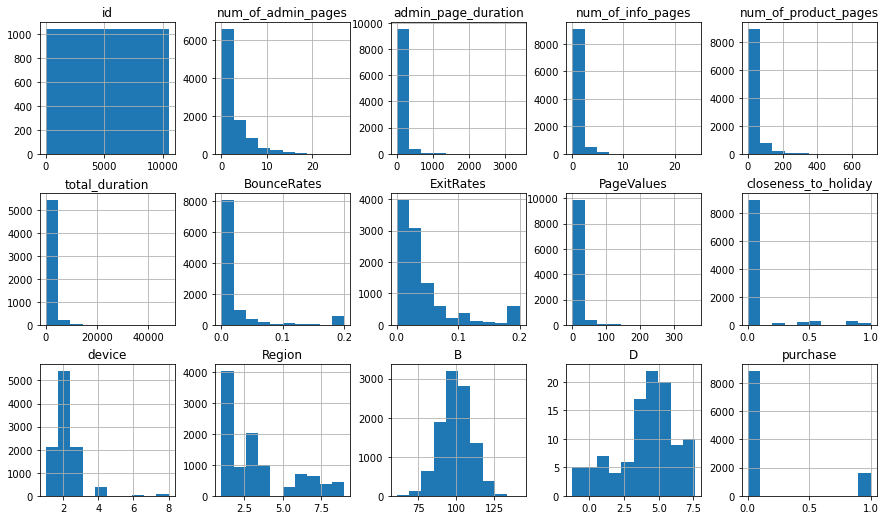

In [10]:
train_data.hist(layout = (5,5), figsize=(15,15));

These two plots help us understand a few things:
1. With the Histogram plot we can see that some of the columns are normally distributed, or close to it - like column "B", "D" and "Device".<br>
2. Others look like they log-normally distributed, like "ExitRates" and "total_duration". These assumptions will help us in the outlier removal stage.<br>
3. The boxplot visualization helps us to identify outliers. For example, we can see that in the total_duration column there's one value that is separated from all the others. This applies also for Region - one of the values is explicitly marked as an outlier.

### Feature correlation:

<AxesSubplot:>

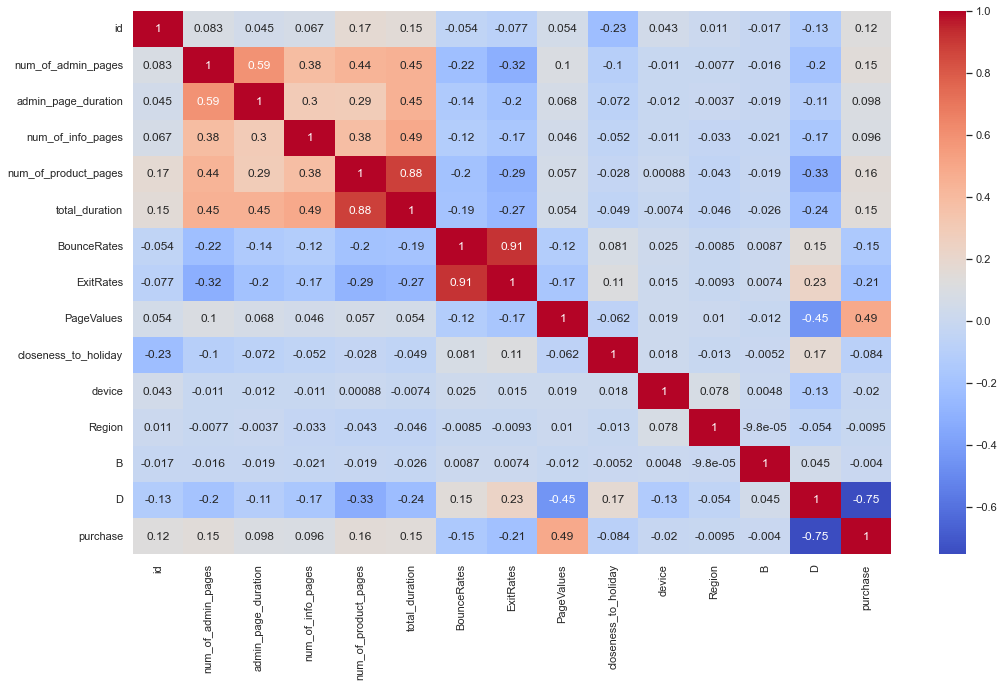

In [12]:
sns.set(rc={'figure.figsize':(17, 10)})
sns.heatmap(train_data.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

Notes from correlation matrix:
&nbsp;
1. **BounceRates and ExitRates have very high correlation** - 0.91 . Looking at the features explenations their meaning sounds very much alike, this can explain the similarity. We can use only one of them,  let's start with using ExitRates as a slightly better correlation with purchase, but we can validate it more thoroughly with methods such as forward selection.
&nbsp;
2. **Pages number and duration** - Total_duration and num_of_product_pages are also highly correlated - 0.98. After learning the relation of the different duration columns before, we can  explain it if most of the session time is dedicated to reviewing products. In general, all those column are relatively correlated and it seems like some of them are redundant. We can choose a strict reduction and take total duraion + only number of pages without duration, or a more "loose" reduction of removing only "total duration" as you can imply it from the other columns.
&nbsp;
3. **D is strongly negatively correlated (-0.75) to purchase,** which is the label we'll be trying to predict. It is interesting as earlier we have noticed most of its values are Nan. Below we've tried to look deeper on the connection between the two by grouping them together and counting how many sessions fit to each combination, and it looks like the ratio of purchase vs not is pretty much the same whether there is D or not.
&nbsp;
4. Other than this, the column most correlated with purchase is **PageValues** (0.49). It also makes sense as usually if the user exists without making a purchase, it hints a 0 value. If a purchase was made, it is very likely the value will be highter than 0. Below a mode detail validation on this theory. We expect to also see this with feature selection.
&nbsp;
&nbsp;
<br>
<br>
__Conclusions:__
- We'll try using only total duration and the number of pages and drop the other durations.
- We'll drop BounceRates and use only ExitRates
Those conclusions should be varified but we'll get to it later when we measure model performance for evaluation.

In [13]:
"""
Check connection between purchase to the existence of page value (higher than 0).
It is noticeable that it's much more likely that if value != 0, a purchase was made and vice versa.
"""
pg_value_to_purchase = pd.DataFrame()
pg_value_to_purchase['purchase'] = train_data['purchase']
pg_value_to_purchase['is_page_value'] = train_data['PageValues'].apply(lambda x: x != 0)
pg_value_to_purchase.groupby(['purchase', 'is_page_value']).size()

purchase  is_page_value
0         False            7829
          True             1029
1         False             309
          True             1312
dtype: int64

According to this table, it seems that the existance of a "page value" can strongly indicate that a purchase was made.

In [14]:
# Check the connection between D and purchase, is it an interesting column to indicate purchase (doesn't seem so)
train_data_d = train_data.copy()
train_data_d['no_D'] = train_data_d.isna().D
train_data_d[['no_D', 'purchase','id']].groupby(['no_D', 'purchase']).count()

id
no_D  purchase      
False 0           90
      1           15
True  0         8768
      1         1606

As it appears, the existence or inexistence isn't much effective in predicting a purchase on its own. We might decide to remove it completly later on.

## Data cleaning

Our end goal is to have all our columns in a numeric form, without missing data.
We can see from the returned values above that there are some columns that should be interpreted as integers, and not as floats (num_of_X_pages, region, device...).
In addition, it wouldn't be smart to assume column "A"'s and "C"'s empty values using KNN, since a value is fixed. We will use a different approach for it.
Moreover, we will fill NaN values for user_type as Others, since we can't assume the real type.<br>

At first, we want to see the unique values of each columns in order to decide what would be the best approach for each:

In [15]:
column_list = train_data.columns.values.tolist()
column_list.sort()
for column_name in column_list:
    if column_name not in ['id', 'purchase']:
        print(f"""Column: "{column_name}" ; Unique values: {list(train_data[column_name].unique())[:15]}""")

Column: "A" ; Unique values: ['c_1', 'c_3', 'c_4', 'c_2', nan, 'c_5', 'c_6', 'c_8', 'c_10', 'c_11', 'c_9', 'c_7', 'c_13', 'c_14', 'c_15']
Column: "B" ; Unique values: [118.8800944, 113.3584226, 121.5076952, 93.74717575, 99.54582421, 104.7124049, 89.78656794, 101.1845339, 83.93173925, 97.89963262, 101.2214824, 95.51998611, 109.3586319, 111.5479879, 113.2126221]
Column: "BounceRates" ; Unique values: [0.2, 0.02, 0.015789474, 0.0, 0.01875, 0.008333333, 0.002857143, 0.05, 0.043478261, 0.04, 0.014285714, 0.015384615, 0.025, 0.028571429, 0.003030303]
Column: "C" ; Unique values: ['log202', 'log404', 'log_100', 'log200', 'log400', 'log8080', nan]
Column: "D" ; Unique values: [nan, 7.257360853, 5.521225205, 4.34878126, 5.011107258, 5.531061246, 3.274955241, 0.796733734, 3.816877219, 0.058866821, 7.618253527, 4.826132322, 3.305456104, 5.386814934, 4.319823481]
Column: "ExitRates" ; Unique values: [0.2, 0.05, 0.024561404, 0.1, 0.022222222, 0.066666667, 0.025833333, 0.028571429, 0.016312636, 0.00

Now that we know which unique values we have in our set, we can transform it in a way that would fit the ML models.<br>

The standardize_data function does the following:
1. Converting boolean data to 0,1
2. Converting month names to numbers
3. Extract numbers from string with words = "23.5 minutes"
4. Browser data - looking carefully on the values, there is a pattern detected - "<browser_name>_<version>" where the version can  be in different patterns and styles. We extract the browser name and later encode it, and the browser version we take only the "major" and ignore the "minor" version part.
5. Categorical data – we decided to convert the categorial columns to Dummy variables. This will add us several new features to consider, but we will try to deal with it with dimensionality reduction.


In [4]:
clean_train_data = standardize_data(train_data, EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder.DUMMY)

The next thing we want to check out is whether we have missing data. We did see in the data glimpse that some of the values are filled with NaNs, so we we'd like to see what's the best way to deal with it.

In [17]:
data_summary = pd.DataFrame()
data_summary['missing'] = clean_train_data.isna().sum()
data_summary['percentile'] = (data_summary.missing / clean_train_data.shape[0]) * 100
data_summary.sort_values(by='missing', ascending=False)

,missing,percentile
D,10374,98.997996
total_duration,4753,45.357381
A,706,6.737284
num_of_info_pages,687,6.555969
product_page_duration,621,5.926138
num_of_admin_pages,605,5.773452
closeness_to_holiday,496,4.733276
admin_page_duration,413,3.941216
num_of_product_pages,403,3.845787
info_page_duration,317,3.025098


As we can see, column "D" and "total_duration" have the most NaN values. Let's try to see what's special about them:

In [18]:
clean_train_data[clean_train_data["D"].notna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Region,Weekend,A,B,C,D,purchase,browser_version,device_1.0,device_2.0,device_3.0,device_4.0,device_5.0,device_6.0,device_7.0,device_8.0,device_other,user_type_New_Visitor,user_type_Other,user_type_Returning_Visitor,user_type_other,browser_name_browser,browser_name_chrome,browser_name_edge,browser_name_safari,browser_name_unknown,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Month_other
34,34,0.0,0.000000,0.0,0.0,9.0,482.0,NaN,0.000000,0.022222,0.000000,0.0,1.0,0,c_6,97.305385,log8080,7.257361,0,5.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
179,179,2.0,40.000000,0.0,0.0,5.0,558.5,598.500000,0.000000,0.028571,0.000000,0.0,7.0,1,c_2,100.425325,log_100,5.521225,0,90.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
222,222,1.0,13.000000,0.0,0.0,2.0,20.0,NaN,0.000000,0.050000,0.000000,0.0,3.0,0,c_2,104.686348,log200,4.348781,0,98.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
328,328,4.0,61.000000,0.0,0.0,14.0,175.666667,NaN,0.000000,0.010588,0.000000,0.0,5.0,0,c_2,93.755824,log202,5.011107,0,80.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
346,346,7.0,151.000000,0.0,0.0,44.0,1406.1,NaN,0.004082,0.006501,0.000000,0.0,4.0,0,c_2,83.061903,log200,5.531061,0,15.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9779,9779,0.0,0.000000,0.0,0.0,12.0,1952.75,NaN,0.033333,0.068333,0.000000,NaN,8.0,0,c_1,115.233372,log404,1.632070,0,99.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
9924,9924,0.0,0.000000,0.0,0.0,57.0,1234.5,NaN,0.001724,0.020690,0.000000,0.0,2.0,1,c_2,90.084329,log400,2.905838,0,7.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10282,10282,10.0,260.250000,0.0,0.0,31.0,1694.333333,1954.583333,0.017143,0.039048,15.108543,0.0,4.0,0,c_3,91.706110,log400,3.932566,0,99.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10388,10388,0.0,0.000000,6.0,97.166667,81.0,3466.794048,NaN,0.018431,0.022050,0.000000,0.0,1.0,1,c_13,80.989223,log_100,4.842721,0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


As there not seems to be much change in the data between empty and non empty "D" values. Since we don't know what column D really stands for, and almost all of the values are empty, we prefer not to try to predict their values, and to remove the column completely.

Let's move to total_duration:

In [19]:
clean_train_data[clean_train_data["total_duration"].notna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Region,Weekend,A,B,C,D,purchase,browser_version,device_1.0,device_2.0,device_3.0,device_4.0,device_5.0,device_6.0,device_7.0,device_8.0,device_other,user_type_New_Visitor,user_type_Other,user_type_Returning_Visitor,user_type_other,browser_name_browser,browser_name_chrome,browser_name_edge,browser_name_safari,browser_name_unknown,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Month_other
1,1,0.0,0.00,0.0,0.0,1.0,0.0,0.000000,0.200000,0.200000,0.000000,0.0,9.0,0,c_3,113.358423,log404,NaN,0,14.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,2,0.0,0.00,0.0,NaN,NaN,627.5,627.500000,0.020000,0.050000,0.000000,0.0,1.0,1,c_4,121.507695,log202,NaN,0,3.0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,3,0.0,0.00,0.0,0.0,19.0,154.216667,154.216667,0.015789,0.024561,0.000000,0.0,1.0,0,c_3,93.747176,log_100,NaN,0,99.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,7,0.0,0.00,0.0,0.0,3.0,395.0,395.000000,0.000000,0.066667,0.000000,0.0,3.0,0,c_3,101.184534,log_100,NaN,0,15.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
9,9,0.0,0.00,0.0,0.0,7.0,280.5,280.500000,0.000000,0.028571,0.000000,0.0,1.0,0,c_3,97.899633,log200,NaN,0,15.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10471,10471,0.0,0.00,0.0,0.0,6.0,0.0,0.000000,0.200000,0.200000,0.000000,0.0,4.0,0,c_1,100.346528,log400,NaN,0,8.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10472,10472,6.0,76.25,0.0,0.0,22.0,1075.25,1151.500000,0.000000,0.004167,0.000000,0.0,4.0,0,c_2,83.053502,log8080,NaN,0,99.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10473,10473,0.0,0.00,1.0,0.0,16.0,503.0,503.000000,0.000000,0.037647,0.000000,0.0,1.0,0,c_1,95.296930,log400,NaN,0,90.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10474,10474,3.0,145.00,0.0,0.0,53.0,1783.791667,1928.791667,0.007143,0.029031,12.241717,0.0,1.0,1,c_1,79.548460,log400,NaN,0,6.0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


It is interesting to notice when all durations columns are filled, that they all sum up to form total duration.
Sometimes we can see that the total_duration column is empty even though other durations are filled with actual values. We will fill the empty values with the sum of the other values and vice versa using this formula: admin_page_duration + info_page_duration + product_page_duration = total_duration

To do this better, we need to try and fill the other duration values.
For other fields, we will use KNN to try and fill-in the missing data. 

We will also remove the columns suggested in the correlation stage ('BounceRates', 'admin_page_duration', 'product_page_duration', 'info_page_duration'), so when we will go over to removing outliers, these columns won't be considered. We also have decided to remove column "D", so we will drop it as well.

The filled_missing_data function does the following:
1. Page durations – first, we wanted to make sure to avoid conflicts between columns. We filled the page duration columns with zeros wherever the total duration equals zero, wherever the number of visited page equals zero and vice versa.
2. Column A – we noticed that the column values are between 1-15, so we filled the missing values with zeros.
3. Column C – since it has very little amount of missing data, we filled it with the most common value.
4. At this point, we used KNN to fill any remaining missing values in all the other columns, except the total duration.
5. At last, we filled the total duration with the sum of the other page duration fields.


In [5]:
filled_train_data = fill_missing_data(clean_train_data)
cols_to_drop =  ['BounceRates', 'admin_page_duration', 'product_page_duration', 'info_page_duration', 'D']
filled_train_data.drop(columns=cols_to_drop, inplace=True)

Finally, let's see that filled in all the NaN values:

In [21]:
data_summary = pd.DataFrame()
data_summary['missing'] = filled_train_data.isna().sum()
data_summary['percentile'] = (data_summary.missing / filled_train_data.shape[0]) * 100
data_summary.sort_values(by='missing', ascending=False)

,missing,percentile
id,0,0.0
num_of_admin_pages,0,0.0
user_type_New_Visitor,0,0.0
user_type_Other,0,0.0
user_type_Returning_Visitor,0,0.0
user_type_other,0,0.0
browser_name_browser,0,0.0
browser_name_chrome,0,0.0
browser_name_edge,0,0.0
browser_name_safari,0,0.0


Wooho! No NaNs! Now that all the data is filled and normalized, we can move on to our models.

### First we will implement it on the test set as well.

In [22]:
clean_test_data = standardize_data(test_data, EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder.DUMMY)
filled_test_data = fill_missing_data(clean_test_data)
filled_test_data.drop(columns=cols_to_drop, inplace=True)

In [23]:
data_summary_test = pd.DataFrame()
data_summary_test['missing'] = filled_test_data.isna().sum()
data_summary_test['percentile'] = (data_summary_test.missing / filled_test_data.shape[0]) * 100
data_summary_test.sort_values(by='missing', ascending=False)

,missing,percentile
id,0,0.0
Month_Aug,0,0.0
user_type_Other,0,0.0
user_type_Returning_Visitor,0,0.0
user_type_other,0,0.0
browser_name_browser,0,0.0
browser_name_chrome,0,0.0
browser_name_edge,0,0.0
browser_name_safari,0,0.0
browser_name_unknown,0,0.0


## Removing outliers

During the data exploration we already notice that our data containes possible outliers.
Outliers could cause our predictions to be inaccurate, so we would like to remove potential outliers before moving forward.
To make sure we remove only absolute outliers, we will use a zscore test.

Zscore test usually applied on normally distributed data. As we previously seen, not all of our colums are normally distributed, but we believe that this will be covered due to the large amount of train data that we have.

We will also exclude some columns from the test, like ID and purchase, so it won't harm the prediction.

The impute_zscore_test function runs the Zscore test with value of 5.5, and returns a DataFrame without the outliers.

In [6]:
# We decided to not remove more than 10% of our data, that's why we picked this z-score as threshold.
Z_SCORE_THRESHOLD = 5.5
train_data_wo_outliers = impute_zscore_test(filled_train_data, Z_SCORE_THRESHOLD, plot=False)

### Now we can run our first model!

We will train and predict with a simple logistic regression. This will help us to have a base line of our expectations and achieved performance, and understand if following operations help or not.

In [7]:
# We will add 'id' and 'purchase' to ignored cols as it is just the row id and should not indicate anything more.
cols_not_in_x_data = ['id', 'purchase']
y = train_data_wo_outliers['purchase']
X = train_data_wo_outliers[[col for col in train_data_wo_outliers.columns if col not in cols_not_in_x_data]]
x_train, x_validation, y_train, y_validation = train_test_split(
       X, y, test_size=0.2, random_state=42, shuffle=True
)

Training set AUC score: 0.8981240325909364


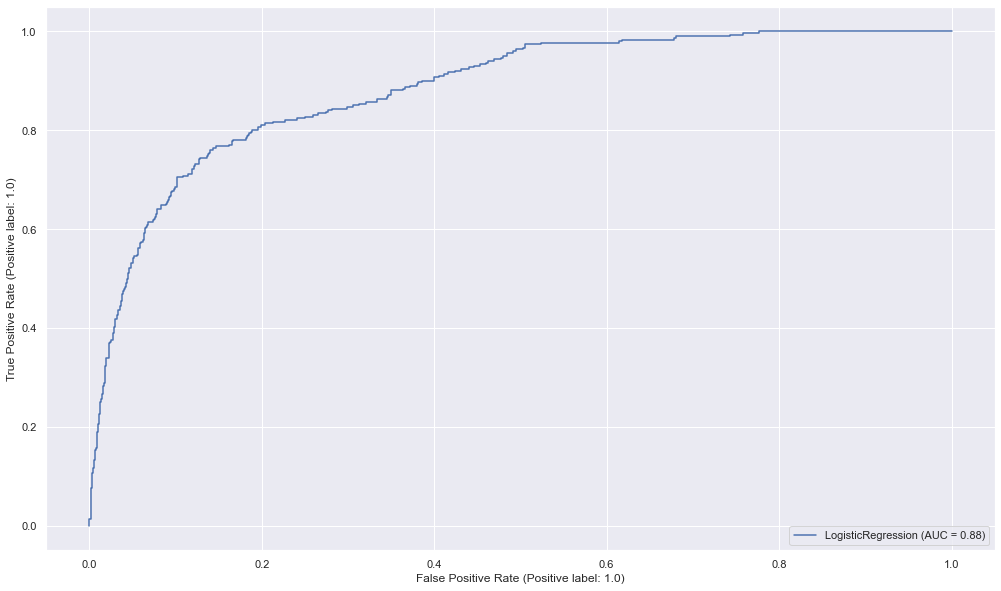

In [42]:

lr = LogisticRegression(max_iter=10000).fit(x_train, y_train)
display = RocCurveDisplay.from_estimator(lr, x_validation, y_validation)

y_pred_train = lr.predict_proba(x_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_train)
print(f"Training set AUC score: {train_auc}")

As it seems, we got pretty good results on this validation set, with AUC score of 0.89 on the validation and training sets. <br>
Honestly, we didn't expect to get such a good result on the first time we run a model. We were concered of overfitting but the fact the we got the same good result on both the validation and training set indicate the model isn't suffering from overfitting.<br>
With that said, we are still going to take some preventative steps to reduce the change of overfitting:<br>
1. Dimensionality reduction - reducing the dimensionality of the data reduces the complexity of it, as more complex models may over fit the data.<br>
2. Regularization - we will use regularization methods such as Lasso or Ridge to reduce the model's complexity. Regularization adds penalty to the model as the complexity increases.<br>
3. K-Fold cross validation - althogh cross validation doesn't prevent the model from being over fitted, it could help us to see if it is suffering from overfitting. Combining it with the other methods will reduce the concern of our model being over-fitted.

## Dimensional Reduction

We will test 2 methods - forward selection and PCA with 0.99 explained variance - and see which yields best performance for each model.
We will be making some assumptions:
1. The performance evaluation will be measured using the model we are about to fit, since we realized that each model has different assumptions on the data, and the same method isn't best for every model. We weren't sure what should be done first - model selection or dimension reduction - so we followed the order of the exercise.
2. The metric for evaluation was chosen to be AUC after researching what metric is more often used for this use case. There is no consensus and different metrics will yield different results.
&nbsp;

To make the assment easy and comfortable, we've build a function running:
1. **Forward selection** - compare each number of features to the one before it and pick the best number of features subset.
2. **PCA** - variance of 0.99 was chosen as a const for not loosing too much of the data. Different consts would yield different results and it is configurable in change this assumption changes.


We will now run it on the test first model we're about to check - Logistic Regression.

In [43]:
lr = LogisticRegression()
compare_pca_and_forward_selection(lr, x_train, y_train, x_validation, y_validation)

PCA AUC: 0.6654080455814787
Best forward selection AUC: 0.6445328711785157
PCA scored best. Better use PCA to reduce dimensions.


The Dimensionality reduction methon that was selected for Logistic Regression is PCA, we will use it in the next part.

## Models

We were asked to run 4 sets of models - 2 simple ones and 2 advanced models.<br>
We are going to compare the following models:
1. Logistic Regression
2. KNN
3. Random Forest
4. MLP

For each of the models, we will first choose the best hyperparameters and once we have them, try and estimate the models performance.
We will do that with an assisting function we wrote, that receives a model and a dataset, and with cross validation returns its accuracy, mse and ROC AUC score, along with confusion matrix.

### Logistic Regresion

We will now implement the Logistic Regression model with the dimensionality reduction method we have selected before (PCA), Ridge penalization and K-Fold Cross Validation.

In [44]:
scaler = StandardScaler()
normalized_x = scaler.fit_transform(X)
normalized_x_train = scaler.fit_transform(x_train)
normalized_x_test = scaler.transform(x_validation)

pca = PCA(0.99)
pca.fit(normalized_x_train)
train_components = pca.components_.T
x_pca_train = np.dot(normalized_x_train, train_components)
x_pca_test = np.dot(normalized_x_test, train_components)

pca.fit(normalized_x)
x_components = pca.components_.T
x_pca = np.dot(normalized_x, x_components)


At first, we will choose the best "C" value for the penalization method. The "C" value is the inverse of the regularization strength - as the value is smaller, the stronger the penalization.
We'd like to choose the smallest "C" value that gives the best score.

In [52]:
# first choose best c

best_c = 0
best_score = 0
c_list = [p/1000 for p in range(0, 1000)][1:]
c_score = []
for c in c_list:
    lr = LogisticRegression(penalty="l2",max_iter=1000000,solver = "liblinear",C=c)
    lr.fit(x_pca_train, y_train)
    score = lr.score(x_pca_test, y_validation)
    if score > best_score:
        best_c = c
        best_score = score
    c_score.append(score)

Best "C" value: 0.063


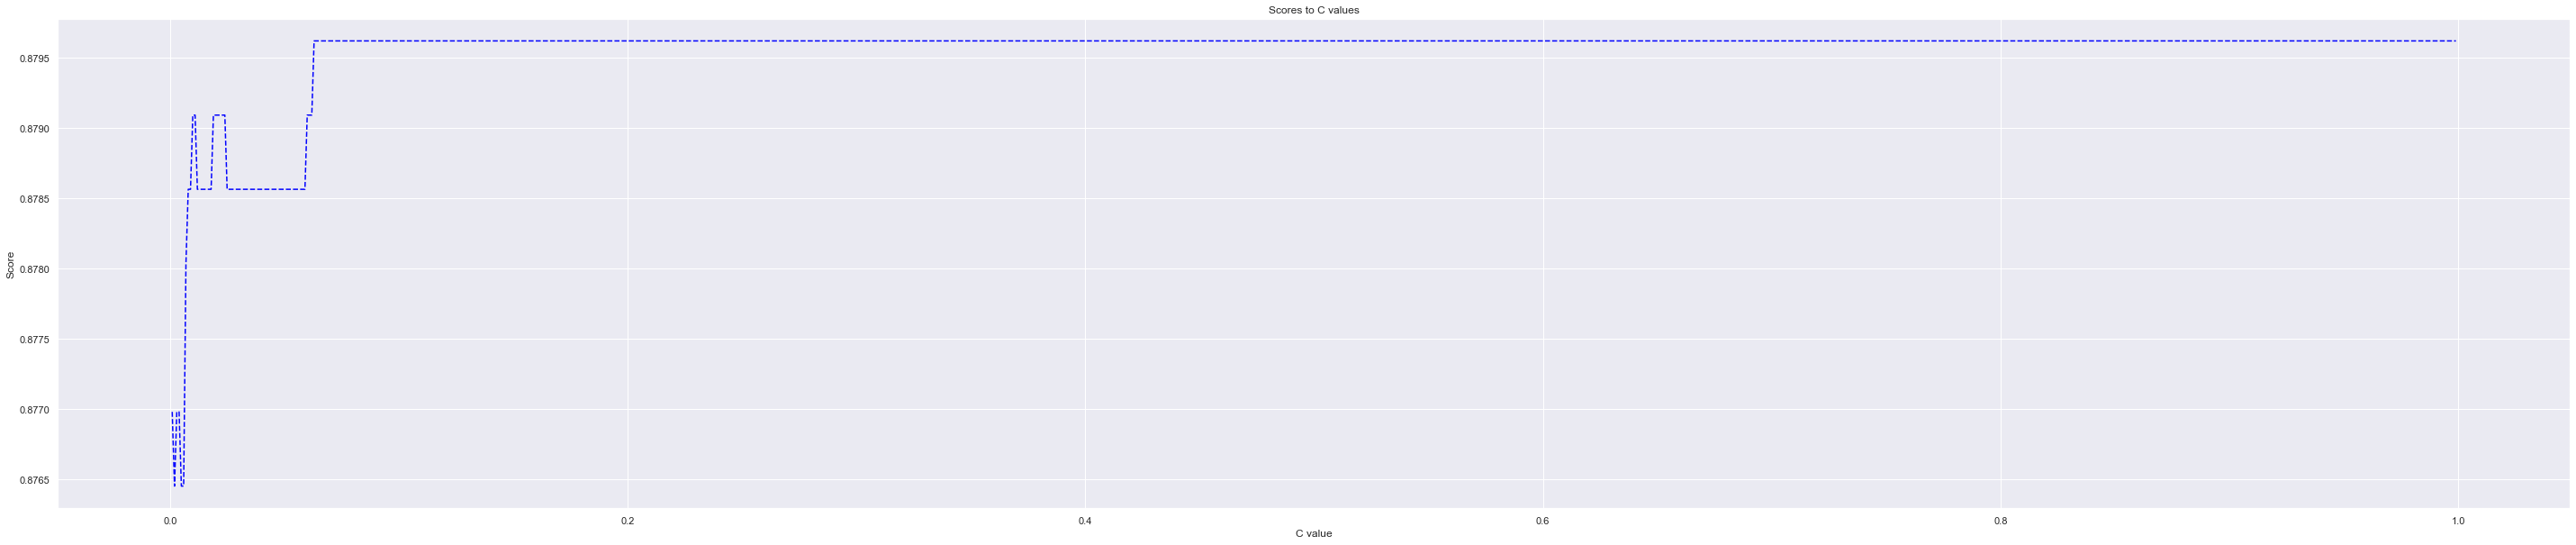

In [53]:
plt.figure(figsize=(50,10))
plt.plot(c_list,c_score,color='blue', linestyle='dashed', 
         markerfacecolor='red', markersize=10)
plt.title('Scores to C values')
plt.xlabel('C value')
plt.ylabel('Score')

print(f"""Best "C" value: {best_c}""")

0.88 test accuracy with a standard deviation of 0.02
0.12 MSE with a standard deviation of 0.02
0.89 train accuracy with a standard deviation of 0.00


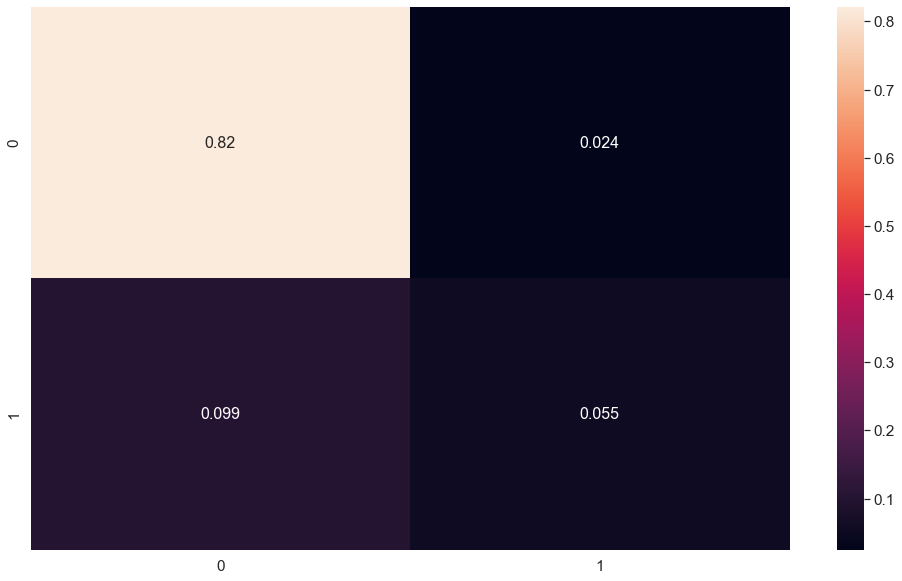

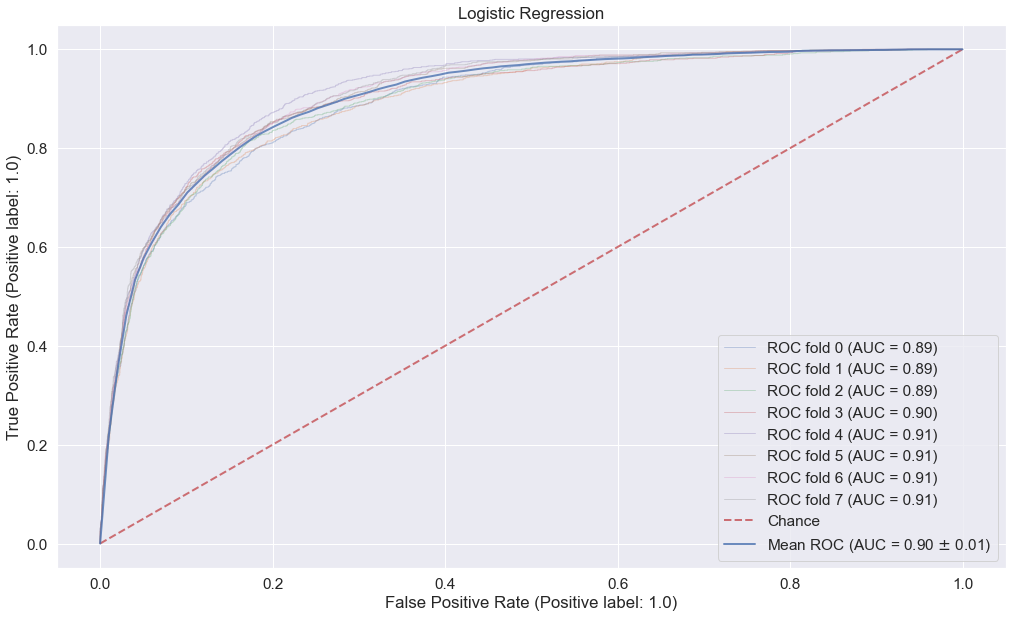

<Figure size 720x720 with 0 Axes>

In [54]:
lr = LogisticRegression(max_iter=1000000, C=best_c, solver = "liblinear", penalty='l2')
estimate_model_performance(lr, "Logistic Regression", pd.DataFrame(x_pca), pd.DataFrame(y), 8);

At this model estimation, we got a better AUC score than the score we got before implemented the aforementioned techniques - with mean AUC of 0.9.<br>
This time, due to the preventative steps we have taken before, we believe that the chance of overfitting has reduced and that our model better fits the data.

### KNN

The next model we are about to test is KNN. As before, we will check which is going to be the best dimensonailty reduction technique for this model.

In [55]:
knn = KNeighborsClassifier()
compare_pca_and_forward_selection(knn, x_train, y_train, x_validation, y_validation)

PCA AUC: 0.6203354376393398
Best forward selection AUC: 0.7285455679227851
Forward Selection scored best. Features to use: ['num_of_admin_pages', 'PageValues', 'Weekend', 'A', 'device_5.0', 'device_6.0', 'device_7.0', 'device_8.0', 'device_other', 'user_type_Other', 'user_type_other', 'browser_name_browser', 'browser_name_unknown', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Sep']


This time, the method that yields the best result is Forward Selection. We will choose the features yielded the best results and run the model.

In [57]:
best_features = ['num_of_admin_pages', 'PageValues', 'Weekend', 'A', 'device_5.0', 'device_6.0',
 'device_7.0', 'device_8.0', 'device_other', 'user_type_Other', 'user_type_other', 'browser_name_browser',
  'browser_name_unknown', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Sep']

x_train_fs = x_train[best_features]
x_validation_fs = x_validation[best_features]
X_fs = X[best_features]

First, we will check which is the best K value to use in this model. We will choose the K value that will yield the lowest Mean Error.
We'd like to verify that we don't choose a K value which is too high, so our model will be less complex.

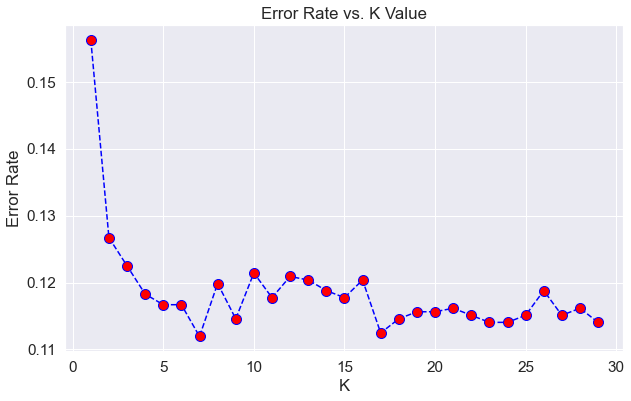

Best K: 7


In [59]:
# Choose best K:
error_rate_list = []
best_k = 0
lowest_mse = 1

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_fs, y_train)
    pred_i = knn.predict(x_validation_fs)
    error_rate = np.mean(pred_i != y_validation)
    error_rate_list.append(error_rate)
    if error_rate < lowest_mse:
        lowest_mse = error_rate
        best_k = i

plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate_list,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()
print(f"Best K: {best_k}")

0.88 test accuracy with a standard deviation of 0.03
0.12 MSE with a standard deviation of 0.03
0.91 train accuracy with a standard deviation of 0.00


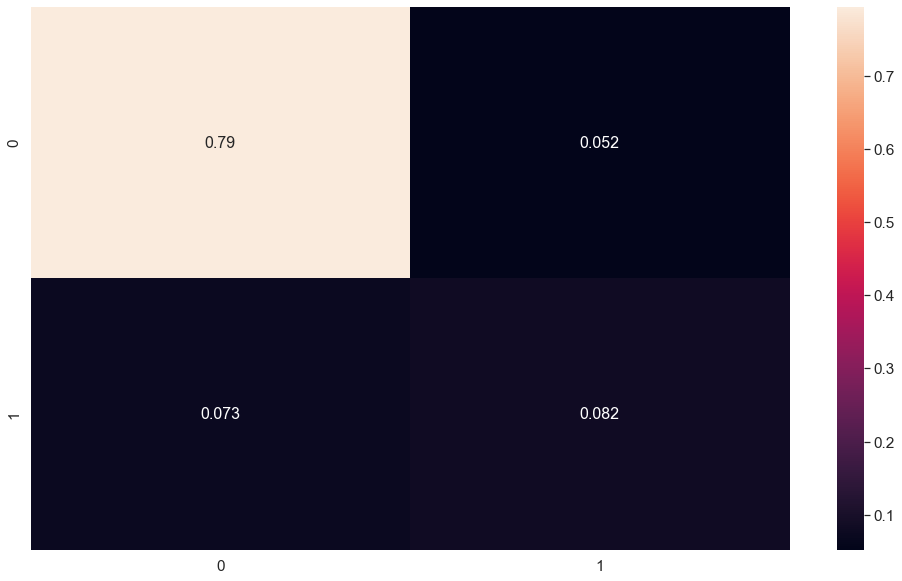

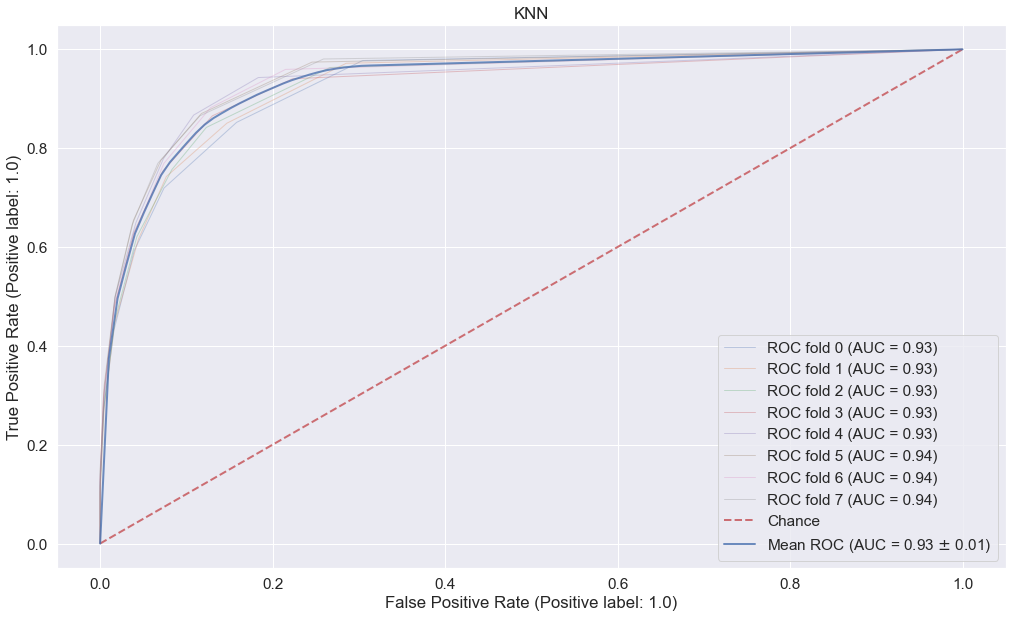

<Figure size 720x720 with 0 Axes>

In [60]:
knn = KNeighborsClassifier(n_neighbors=best_k)
estimate_model_performance(knn, "KNN", X_fs, y, 8)

The KNN model yielded a slightly better AUC score than the Logistic Regression, with AUC score of 0.93.

## Random Forest

We will compare again PCA and forward selection to see which yields the best result for Random Forest.

In [65]:
rfs = RandomForestClassifier()
compare_pca_and_forward_selection(rfs, x_train, y_train, x_validation, y_validation)

PCA AUC: 0.6382022261013195
Best forward selection AUC: 0.7411150944852167
Forward Selection scored best. Features to use: ['num_of_admin_pages', 'PageValues', 'closeness_to_holiday', 'Weekend', 'device_1.0', 'device_4.0', 'device_5.0', 'device_6.0', 'device_7.0', 'device_8.0', 'device_other', 'user_type_Other', 'user_type_other', 'browser_name_unknown', 'Month_Feb', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Sep', 'Month_other']


Here as well, the best method is Forward Selection.

In [8]:
best_features = ['num_of_admin_pages', 'PageValues', 'closeness_to_holiday', 'Weekend', 'device_1.0', 'device_4.0', 'device_5.0',
 'device_6.0', 'device_7.0', 'device_8.0', 'device_other', 'user_type_Other', 'user_type_other',
 'browser_name_unknown', 'Month_Feb', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Sep', 'Month_other']

x_train_fs = x_train[best_features]
x_validation_fs = x_validation[best_features]
x_fs = X[best_features]

Before running the predictions, we will investigate the different hyperparameters focusing on 3 different ones:
1. n_estimators - number of trees in the forest.
2. max_depth - depth levels of each tree
3. min_samples_split - minumum samples required for a split in the tree.

In [69]:
parameters = {
    'n_estimators': range(20, 100, 10), # Limited subset not to exceed the runtime limitation
    'max_depth': range(3, 10),
    'min_samples_split': range(2, 5)
    }
clf = RandomForestClassifier()
gscv = GridSearchCV(clf, parameters, scoring='roc_auc', error_score='raise')
gscv.fit(X_fs, y)

best_params = gscv.best_params_
best_score = gscv.best_score_
print(f'Best Params: {best_params} \n')
print(f'Train AUC score for best params: {best_score}')


Best Params: {'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 90} 

Train AUC score for best params: 0.9106322520556761


0.88 test accuracy with a standard deviation of 0.01
0.12 MSE with a standard deviation of 0.01
0.92 train accuracy with a standard deviation of 0.00


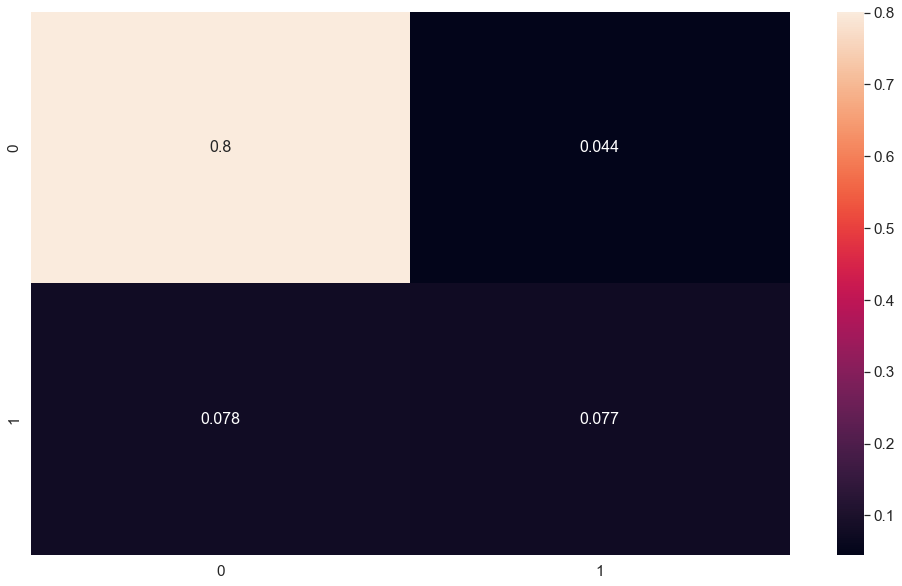

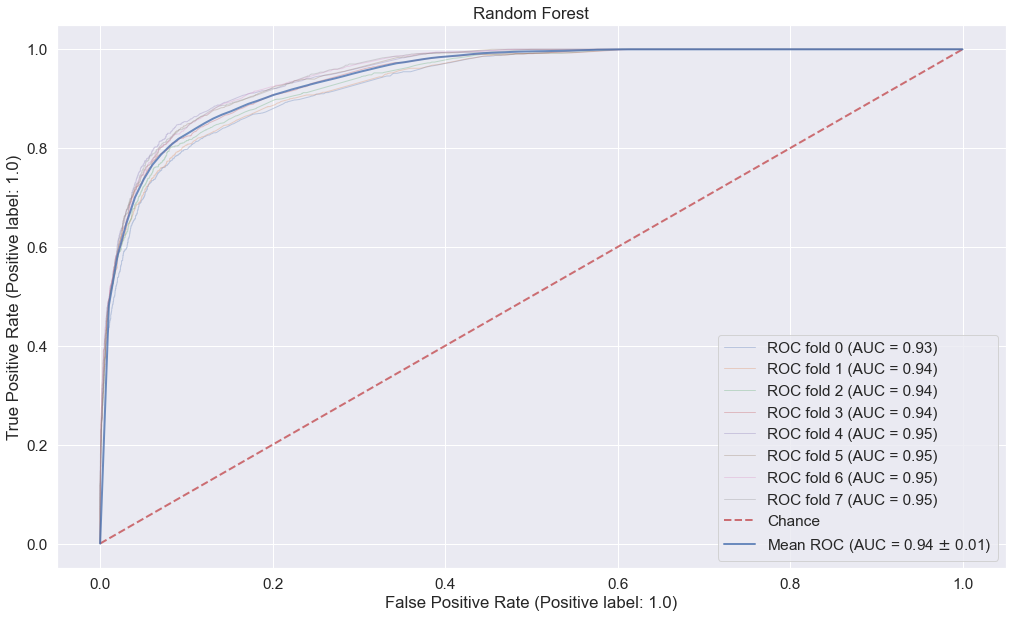

<Figure size 720x720 with 0 Axes>

In [70]:
clf = RandomForestClassifier(**best_params)
estimate_model_performance(clf, 'Random Forest', x_fs, y, 8)

The algorithm yields an outstanding results - Mean AUC score of 0.94.
The reason for it can be the grid search that optimized its parameter in the best manner, or the way the data itself behaves.<br><br>

### Feature Importance
The random forest algorithm also contains a feature importance feature that will help us learn which features were most important for this score (it will only work with :

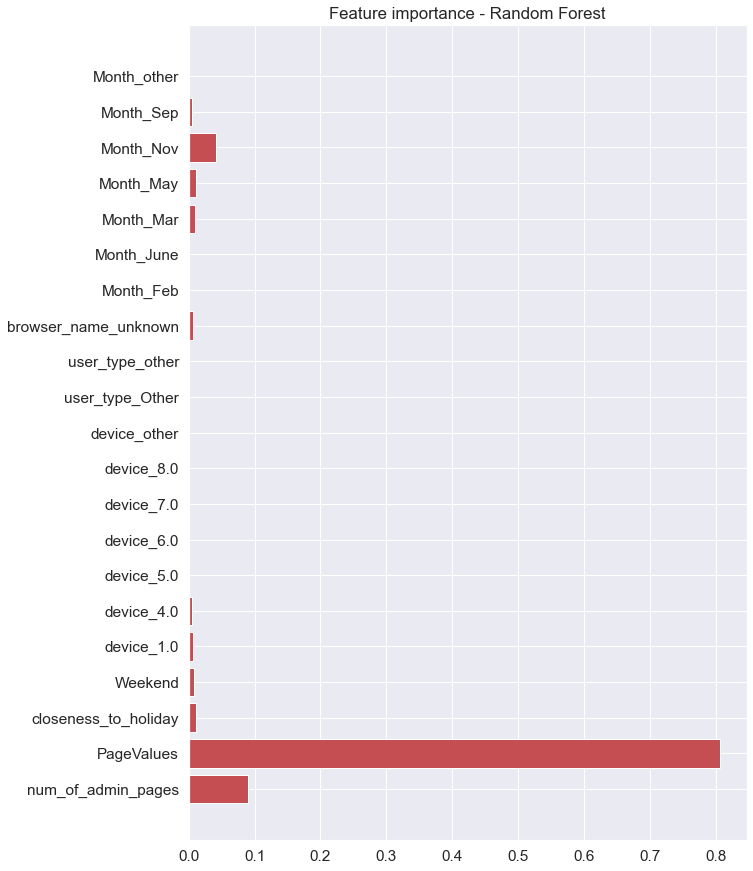

In [71]:
plt.figure(figsize=(10,15))
plt.barh(clf.feature_names_in_, clf.feature_importances_, color='r')
# plt.xticks(clf.feature_names_in_, rotation=90)
plt.title("Feature importance - Random Forest");

We will try to explain why these features are the best the were chosen by the model:<br>
1. PageValues - according to the model, this is the most important feature. According to the feature information we received, this indicates an average value for a page that a user visited, before landing on the goal page or completing a transaction. Since we are trying to predict which e-commerce sessions are ending with a purchase, it makes a perfect sense that higher PageValues will be given to sessions that eventually ended up with a purchase. In addition, according to the Google Analytics PageValue explanation, a PageValue of 0 indicates that the session didn't end with a transaction - which also makes it an exteremly strong feature to predict purchases.<br>
2. num_of_admin_pages - although it's less obvius than the PageValues feature, it is understandable that users, especially returning visitors, that are taking care of their app/website settings and profile are more engaged users, with a higher chance of purchasing items at the end of their sessions.
3. Month_nov - November is the month that people prepare to the holidays season. With Thanksgiving happening on November 24th, and Christmass (and New Year's Eve) only a month later, November is the last month to prepare to these events. According to this infographic by Yesmail (https://www.rcs-uk.com/people-start-shopping-for-christmas/#shopping-infographic), 31% of the people start their shopping for Christmas on November.
4. closeness_to_holiday - basically speaks for itself. People tend to but more when the holidays are approacing. According to this article by Finical (https://finicalholdings.com/us-holiday-shopping-statistics/), in 2020 holiday shopping made up 19.5% of total annual retail income.


## Multi-Layer Perceptron

The second advanced model we're about to run is MLP.<br>
<br>
We tried to compare PCA and Forward Selection here as well, but the run takes over an hour. Instead, we will check our model with PCA, and then with the same subset of feature that were selected with the Random Forest model, and see which yields the best result.

We will also use GridSearchCV in order to choose the best hyperparameters for the model.<br>
<br>The hyperparameters we will let GridSeaechCV to choose are:<br>
1. hidden_layer_sizes - number of neurons in the hidden layer.
2. alpha - the strength of the Ridge penalization.

First, let's see PCA results:

In [11]:
hidden_layers_list = []
for i in range(10,100,10):
    hidden_layers_list.append((i, ))  # Limited subset not to exceed the runtime limitation

In [80]:

params = {
    'hidden_layer_sizes': hidden_layers_list,
    'alpha': [0.0001, 0.1, 1]
}

mlp = MLPClassifier()
clf = GridSearchCV(mlp, params, scoring='roc_auc')
clf.fit(x_pca, y)

best_params = clf.best_params_
best_score = clf.best_score_
print(f'Best Params: {best_params} \n')
print(f'Train AUC score for best params: {best_score}')


Best Params: {'alpha': 1, 'hidden_layer_sizes': (80,)} 

Train AUC score for best params: 0.9010349822028247


0.89 test accuracy with a standard deviation of 0.02
0.11 MSE with a standard deviation of 0.02
0.91 train accuracy with a standard deviation of 0.00


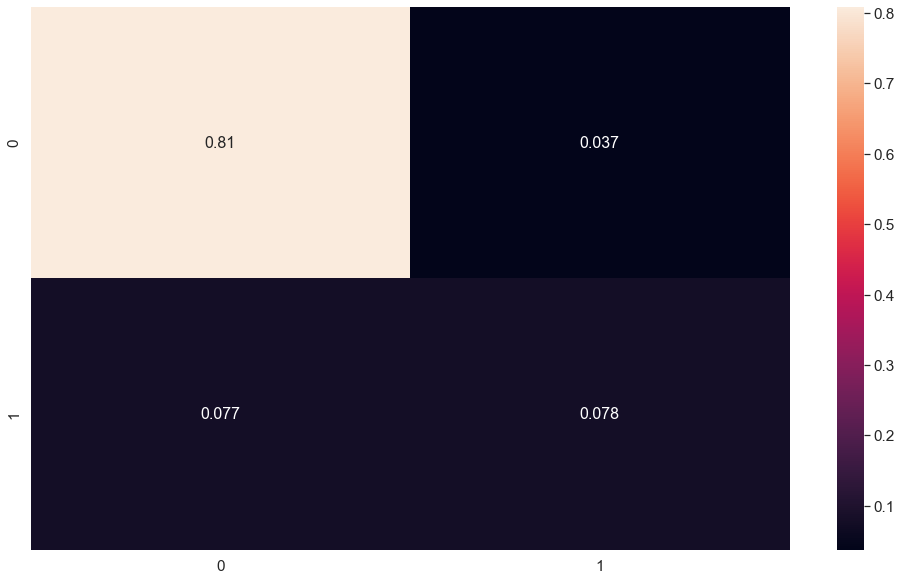

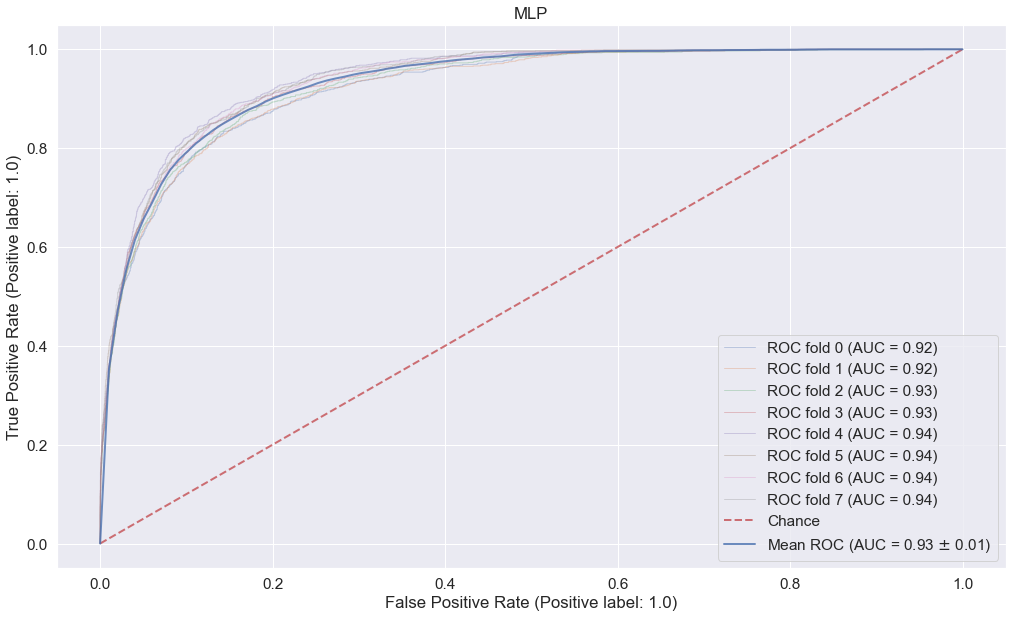

<Figure size 720x720 with 0 Axes>

In [81]:
mlp = MLPClassifier(**best_params)
estimate_model_performance(mlp, "MLP", pd.DataFrame(x_pca), pd.DataFrame(y), 8)

The MLP model with PCA yielded an outstanding result - AUC of 0.93. Now we will try the Forward Selection:

In [12]:
params = {
    'hidden_layer_sizes': hidden_layers_list,
    'alpha': [0.0001, 0.1, 1]
}

mlp = MLPClassifier()
clf = GridSearchCV(mlp, params, scoring='roc_auc')
clf.fit(x_fs, y)

best_params = clf.best_params_
best_score = clf.best_score_
print(f'Best Params: {best_params} \n')
print(f'Train AUC score for best params: {best_score}')

Best Params: {'alpha': 1, 'hidden_layer_sizes': (30,)} 

Train AUC score for best params: 0.9094800165089774


0.89 test accuracy with a standard deviation of 0.02
0.11 MSE with a standard deviation of 0.02
0.90 train accuracy with a standard deviation of 0.00


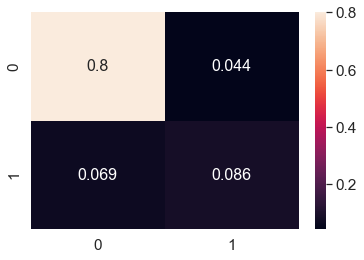

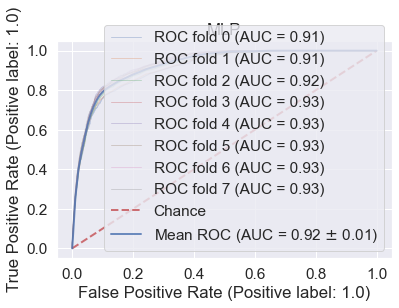

<Figure size 720x720 with 0 Axes>

In [13]:
mlp = MLPClassifier(**best_params)
estimate_model_performance(mlp, "MLP", pd.DataFrame(x_fs), pd.DataFrame(y), 8)

Seems like the PCA scored better result, while FS scored an AUC of 0.92.

# Prediction

After running all the models, it appears that the model that scored the best AUC score is Random Forest, with AUC of 0.94.<br>
We will use it as the final model, with these parametrs:<br>
1. Features that were selected from Forward Selection: ['num_of_admin_pages', 'PageValues', 'closeness_to_holiday', 'Weekend', 'device_1.0', 'device_4.0', 'device_5.0', 'device_6.0', 'device_7.0', 'device_8.0', 'device_other', 'user_type_Other', 'user_type_other', 'browser_name_unknown', 'Month_Feb', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Sep', 'Month_other']
2. max_depth = 9
3. min_samples_split = 3
4. n_estimators = 90
<br>
<br>

We will now add the final pipeline to the notebook. The final pipeline module does the following:
1. Standardize and filling the data the way that showed in the notebook.
2. Reduces dimenionality using the features that are mentioned above.
3. Removes outliers with Zscore test with value of 5.5.
4. Fits the Random Forest on the entire train data, with the aforementioned hyperparameters.
5. Using the same methods on the test set (except for removing outliers).
6. Predicts the test labels and saving it to a CSV file.

In [15]:
pipeline = PredictionsPipeline()
pipeline.train('train.csv')
pipeline.predict_to_file('test.csv', None)